在前面的章节中，我们遇到过图像数据。这种数据的每个样本都由一个二维像素网格组成，每个像素可能是一个或者多个数值，这取决于是黑白还是彩色图像。
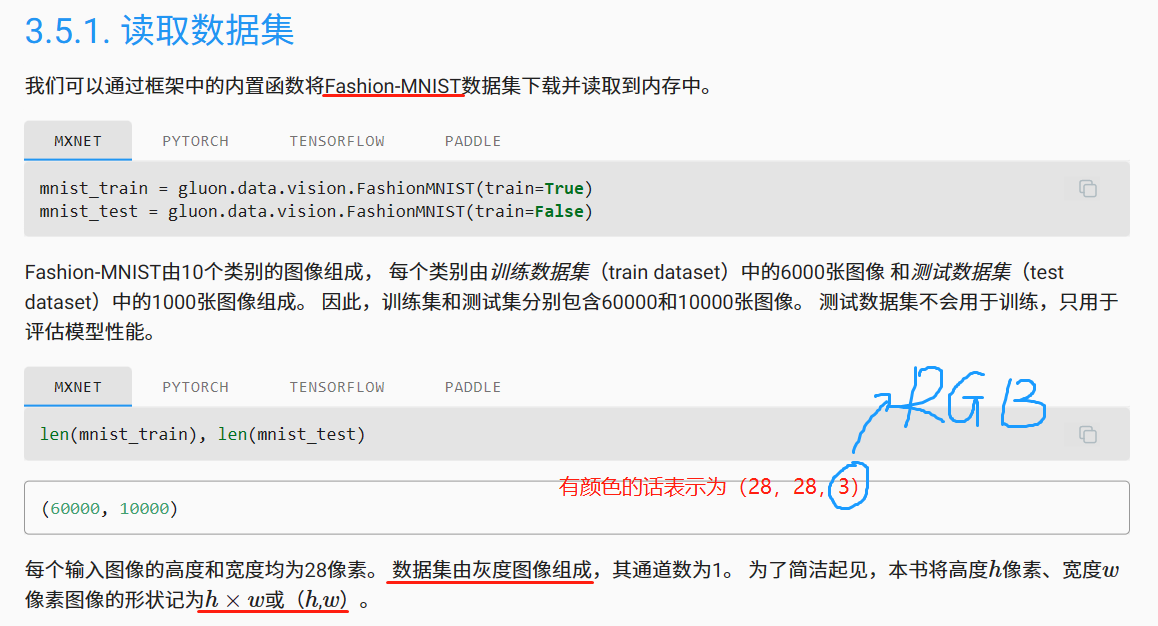

回忆一下，前面对图形的处理分类操作：将图像数据展平成一维向量，再将数据送入一个全连接的多层感知机中。

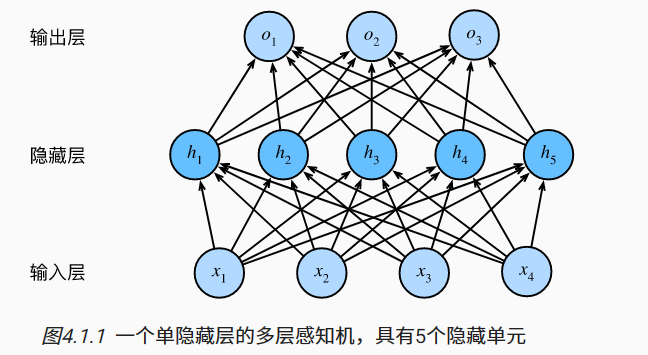

那么图像的空间结构信息如何体现呢？

图像的网络特征元素的顺序是不变的，因此最优的结果是利用相近像素之间的相互关联性，从图像数据中学习得到有效的模型。

本章介绍的卷积神经网络（convolutional neural network，CNN）是一类强大的、为处理图像数据而设计的神经网络。

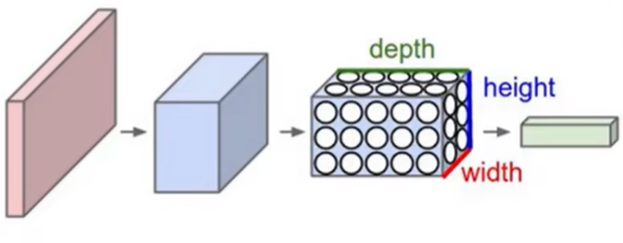


## 6.1. 从全连接层到卷积

为什么要使用卷积层？

——“结构性”，结构能反应信息。

——储存的参数数量，影响内存及速度。

例如，在之前猫狗分类的例子中：假设我们有一个足够充分的照片数据集，数据集中是拥有标注的照片，每张照片具有百万级像素，这意味着网络的每次输入都有一百万个维度。 即使将隐藏层维度降低到1000，这个全连接层也将有$10^6×10^3=10^9$个参数。想要训练这个模型将不可实现，因为需要有大量的GPU、分布式优化训练的经验和超乎常人的耐心。此外，拟合如此多的参数还需要收集大量的数据。

因此，卷积神经网络的结构性是一种学习图像特征的创造性方法。

### 6.1.1 不变性

想象一下，假设我们想从一张图片中找到某个物体。 合理的假设是：无论哪种方法找到这个物体，都应该和物体的位置无关。

我们可以从儿童游戏”沃尔多在哪里”中得到灵感： 在这个游戏中包含了许多混乱的场景，而沃尔多通常潜伏在一些不太可能的位置，读者的目标就是找出他。尽管沃尔多的装扮很有特点，但是在眼花缭乱的场景中找到他也如大海捞针。 然而沃尔多的样子并不取决于他潜藏的地方，因此我们可以使用一个“沃尔多检测器”扫描图像。 该检测器将图像分割成多个区域，并为每个区域包含沃尔多的可能性打分。 

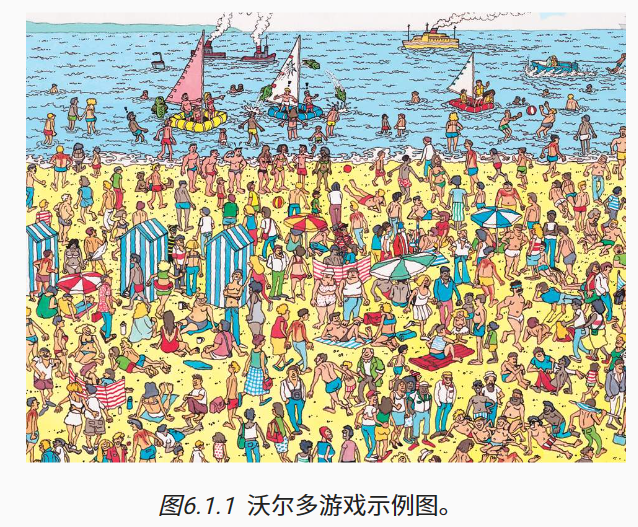

卷积神经网络正是将空间不变性（spatial invariance）的这一概念系统化，从而使用较少的参数来学习有用的表示。

<center>
<img src="https://ts1.cn.mm.bing.net/th/id/R-C.d2aa9320e2b5356c1f89c4cf846adf14?rik=sYxwR5j2BboVCQ&riu=http%3a%2f%2fimgtec.eetrend.com%2ffiles%2f2019-12%2f%e5%8d%9a%e5%ae%a2%2f100046825-87704-14.gif&ehk=%2f1UO9Yv%2ffpU3MVncmqBN%2fyvtn6eVBrMqfuN2rYB3VpI%3d&risl=&pid=ImgRaw&r=0" width=300>
</center>


我们将上述想法总结一下，从而帮助我们设计适合于计算机视觉的神经网络架构。

- 平移不变性（translation invariance）：不管检测对象出现在图像中的哪个位置，神经网络的前面几层应该对相同的图像区域具有相似的反应，即为“平移不变性”。

- 局部性（locality）：神经网络的前面几层应该只探索输入图像中的局部区域，而不过度在意图像中相隔较远区域的关系，这就是“局部性”原则。最终，可以聚合这些局部特征，以在整个图像级别进行预测。

### 6.1.2 多层感知机的限制

首先，多层感知机的输入是二维图像X，其隐藏表示H在数学上是一个矩阵，在代码中表示为二维张量。 其中X和H具有相同的形状。 为了方便理解，我们可以认为，无论是输入还是隐藏表示都拥有空间结构。

使用$[X]_{i,j}$和$[H]_{i,j}$分别表示输入图像和隐藏表示中位置（i,j）处的像素。 为了使每个隐藏神经元都能接收到每个输入像素的信息，我们将参数从权重矩阵（如同我们先前在多层感知机中所做的那样）替换为四阶权重张量W。假设U包含偏置参数，我们可以将全连接层形式化地表示为\begin{split}\begin{aligned} \left[\mathbf{H}\right]_{i, j} &= [\mathbf{U}]_{i, j} + \sum_k \sum_l[\mathsf{W}]_{i, j, k, l}  [\mathbf{X}]_{k, l}\\ &=  [\mathbf{U}]_{i, j} +
\sum_a \sum_b [\mathsf{V}]_{i, j, a, b}  [\mathbf{X}]_{i+a, j+b}.\end{aligned}\end{split}

其中，从W到V的转换只是形式上的转换，因为在这两个四阶张量的元素之间存在一一对应的关系。 我们只需重新索引下标(k,l)，使$k=i+a$、$l=j+b$，由此可得$[V]_{i,j,a,b}=[W]_{i,j,i+a,j+b}$。 索引a和b通过在正偏移和负偏移之间移动覆盖了整个图像。 对于隐藏表示中任意给定位置（i,j）处的像素值$[H]_{i,j}$，可以通过在x中以(i,j)为中心对像素进行加权求和得到，加权使用的权重为$[V]_{i,j,a,b}$。

#### 平移不变性

平移不变性意味着检测对象在输入X中的平移，应该仅导致隐藏表示H中的平移。也就是说，V和U实际上不依赖于(i, j)的值，即$[V]_{i, j, a, b} = [V]_{a, b}$。并且U是一个常数，比如u。因此，我们可以简化H定义为$$[H]_{i, j} = u + \sum_a\sum_b [{V}]_{a, b} [X]_{i+a, j+b}$$

这就是卷积（convolution）。我们是在使用系数$[V]_{a, b}$对位置(i,j)附近的像素(i+a,j+b)进行加权得到$[H]_{i, j}$。 注意，$[V]_{a, b}$的系数比$[V]_{i,j,a,b}$少很多，因为前者不再依赖于图像中的位置。这就是显著的进步。


#### 局部性

为了收集用来训练参数$[H]_{i,j}$的相关信息，我们不应偏离很远。这意味着在
$|a|> \Delta$或$|b|> \Delta$的范围之外，可以设置$[V]_{a,b}=0$。因此，我们可以将$[H]_{i,j}$重写为$$[H]_{i, j} = u + \sum_{a = -\Delta}^{\Delta} \sum_{b = -\Delta}^{\Delta} [V]_{a, b}  [X]_{i+a, j+b}$$

以上表示的是一个卷积层，而卷积神经网络是包含卷积层的一类特殊的神经网络。 它还可以称为卷积核（convolution kernel）或者filter，亦或简单地称之为该卷积层的权重，通常该权重是需要反向传播学习的参数。

### 6.1.3. 卷积

在进一步讨论之前，我们先简要回顾一下为什么上面的操作被称为卷积。在数学中，两个函数（比如$f, g: \mathbb{R}^d \to \mathbb{R}$）之间的“卷积”被定义为$$(f * g)(\mathbf{x}) = \int f(\mathbf{z}) g(\mathbf{x}-\mathbf{z}) d\mathbf{z}$$

也就是说，卷积是当把一个函数“翻转”并移位x时，测量f和g之间的重叠。 当为离散对象时，积分就变成求和。

### 6.1.4. “沃尔多在哪里”回顾

回到上面的“沃尔多在哪里”游戏，让我们看看它到底是什么样子。卷积层根据filter选取给定大小的窗口，并加权处理图片，我们的目标是学习一个模型，以便探测出在“沃尔多”最可能出现的地方。

<center>
<img src="https://zh-v2.d2l.ai/_images/waldo-mask.jpg" width=500>
</center>

#### 6.1.4.1. 通道

运用以上方法我们会忽略一个问题——图像的颜色。实际上，图像不是二维张量，而是一个由高度、宽度和颜色组成的三维张量，比如包含1024×1024×3个像素。 前两个轴与像素的空间位置有关，而第三个轴可以看作每个像素的多维表示。因此，我们将X索引为$[X]_{i, j, k}$。由此卷积相应地调整为$[\mathsf{V}]_{a,b,c}$，而不是$[\mathbf{V}]_{a,b}$。

此外，由于输入图像是三维的，我们的隐藏表示H也最好采用三维张量。这样一组隐藏表示可以想象成一些互相堆叠的二维网格。 因此，我们可以把隐藏表示想象为一系列具有二维张量的通道（channel）。 这些通道有时也被称为特征映射（feature maps），因为每个通道都向后续层提供一组空间化的学习特征。

为了支持输入X和隐藏表示H中的多个通道，我们可以在V中添加第四个坐标，即$[\mathsf{V}]_{a, b, c, d}$。综上所述可以得到：$$[\mathsf{H}]_{i,j,d} = \sum_{a = -\Delta}^{\Delta} \sum_{b = -\Delta}^{\Delta} \sum_c [\mathsf{V}]_{a, b, c, d} [\mathsf{X}]_{i+a, j+b, c},$$

## 6.2. 图像卷积

### 6.2.1. 互相关运算

严格来说，卷积层是个错误的叫法，因为它所表达的运算其实是互相关运算（cross-correlation），而不是卷积运算。 根据前文的描述，在卷积层中，输入张量和卷积核张量通过互相关运算产生输出张量。

首先，我们暂时忽略通道（第三维）这一情况，看看如何处理二维图像数据和隐藏表示。

<center>
<img src="https://zh-v2.d2l.ai/_images/correlation.svg" width=500>
</center>

阴影部分是第一个输出元素，以及用于计算输出的输入张量元素和核张量元素：0×0+1×1+3×2+4×3=19

在二维互相关运算中，卷积窗口从输入张量的左上角开始，从左到右、从上到下滑动。 当卷积窗口滑动到新一个位置时，包含在该窗口中的部分张量与卷积核张量进行按元素相乘，得到的张量再求和得到一个单一的标量值，由此我们得出了这一位置的输出张量值。当然需要注意，在得到最终结果的时候需要加入偏置Bias的数据。

注意，输出大小略小于输入大小。这是因为卷积核的宽度和高度大于1， 而卷积核只与图像中每个大小完全适合的位置进行互相关运算。 所以，输出大小等于输入大小$n_h \times n_w$减去卷积核大小$k_h \times k_w$，即：$$(n_h-k_h+1) \times (n_w-k_w+1)$$

接下来，我们在corr2d函数中实现如上过程，该函数接受输入张量X和卷积核张量K，并返回输出张量Y。

In [4]:
import torch
from torch import nn

def corr2d(X, K): 
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

### 6.2.2. 卷积层

卷积层对输入和卷积核权重进行互相关运算，并在添加标量偏置之后产生输出。 所以，卷积层中的两个被训练的参数是卷积核权重和标量偏置。 就像我们之前随机初始化全连接层一样，在训练基于卷积层的模型时，我们也随机初始化卷积核权重。

基于上面定义的corr2d函数实现二维卷积层。在__init__构造函数中，将weight和bias声明为两个模型参数。前向传播函数调用corr2d函数并添加偏置。

In [5]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

高度和宽度分别为h和w的卷积核可以被称为h×w卷积或h×w卷积核。

### 6.2.3. 图像中目标的边缘检测

如下是卷积层的一个简单应用：通过找到像素变化的位置，来检测图像中不同颜色的边缘。 首先，我们构造一个6×8像素的黑白图像。中间四列为黑色（0），其余像素为白色（1）

In [7]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

接下来，我们构造一个高度为1、宽度为2的卷积核K。当进行互相关运算时，如果水平相邻的两元素相同，则输出为零，否则输出为非零。

In [8]:
K = torch.tensor([[1.0, -1.0]])

现在，我们对参数X（输入）和K（卷积核）执行互相关运算。 如下所示，输出Y中的1代表从白色到黑色的边缘，-1代表从黑色到白色的边缘，其他情况的输出为0。

In [9]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

现在我们将输入的二维图像转置，再进行如上的互相关运算。 其输出如下，之前检测到的垂直边缘消失了。 不出所料，这个卷积核K只可以检测垂直边缘，无法检测水平边缘。

In [10]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

### 6.2.4. 学习卷积核

在上述例子中，我们手动设计了卷积核，那么我们是否可以学习由X生成Y的卷积核呢？

现在让我们看看是否可以通过仅查看“输入-输出”对来学习由X生成Y的卷积核。 我们先构造一个卷积层，并将其卷积核初始化为随机张量。接下来，在每次迭代中，我们比较Y与卷积层输出的平方误差，然后计算梯度来更新卷积核。为了简单起见，我们在此使用内置的二维卷积层，并忽略偏置。

In [11]:
# 构造一个二维卷积层，它具有1个输出通道和形状为（1，2）的卷积核
conv2d = nn.Conv2d(1,1, kernel_size=(1, 2), bias=False)

# 这个二维卷积层使用四维输入和输出格式（批量大小、通道、高度、宽度），
# 其中批量大小和通道数都为1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2  # 学习率

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # 迭代卷积核
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i+1}, loss {l.sum():.3f}')

epoch 2, loss 11.050
epoch 4, loss 2.221
epoch 6, loss 0.523
epoch 8, loss 0.149
epoch 10, loss 0.050


在10次迭代之后，误差已经降到足够低。现在我们来看看我们所学的卷积核的权重张量。

In [12]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 0.9626, -1.0053]])

由结果可知，学习到的卷积核权重非常接近我们之前定义的卷积核K（1，-1）

### 6.2.5. 互相关和卷积

由于卷积核是从数据中学习到的，因此无论这些层执行严格的卷积运算还是互相关运算，卷积层的输出都不会受到影响。为了与深度学习文献中的标准术语保持一致，我们将继续把“互相关运算”称为卷积运算，尽管严格地说，它们略有不同。 此外，对于卷积核张量上的权重，我们称其为元素。

### 6.2.6. 特征映射和感受野

在前面的描述中，图像通过卷积得到的输出有时被称为特征映射（feature map），因为它可以被视为一个输入映射到下一层的空间维度的转换。

在卷积神经网络中，对于某一层的任意元素x，其感受野（receptive field）是指在前向传播期间可能影响x计算的所有元素（来自所有先前层）。

<center>
<img src="https://tse3-mm.cn.bing.net/th/id/OIP-C.JlpY9Jw9Vm7evuQNwrhIzgHaE7?pid=ImgDet&rs=1" width=500>
</center>

## 6.3. 填充和步幅

试想一下，有时，在应用了连续的卷积之后，我们最终得到的输出远小于输入大小。这是由于卷积核的宽度和高度通常大于1所导致的。比如，一个240×240像素的图像，经过10层5×5的卷积后，将减少到200×200像素。如此一来，原始图像的边界丢失了许多有用信息。如何解决这一问题呢？

### 6.3.1. 填充

如上所述，在应用多层卷积时，我们常常丢失边缘像素。 由于我们通常使用小卷积核，因此对于任何单个卷积，我们可能只会丢失几个像素。 但随着我们应用许多连续卷积层，累积丢失的像素数就多了。 解决这个问题的简单方法即为填充（padding）：在输入图像的边界填充元素（通常填充元素是0）。

<center>
<img src="https://zh-v2.d2l.ai/_images/conv-pad.svg" width=500>
</center>

通常，如果我们添加$p_h$行填充（大约一半在顶部，一半在底部）和$p_w$列填充（左侧大约一半，右侧一半），则输出形状将为$$(n_h-k_h+p_h+1)\times(n_w-k_w+p_w+1)。$$

这意味着输出的高度和宽度将分别增加$p_h$和$p_w$

在下面的例子中，我们创建一个高度和宽度为3的二维卷积层，并在所有侧边填充1个像素。给定高度和宽度为8的输入，则输出的高度和宽度也是8。

In [13]:
import torch
from torch import nn


# 为了方便起见，我们定义了一个计算卷积层的函数。
# 此函数初始化卷积层权重，并对输入和输出提高和缩减相应的维数
def comp_conv2d(conv2d, X):
    # 这里的（1，1）表示批量大小和通道数都是1
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # 省略前两个维度：批量大小和通道
    return Y.reshape(Y.shape[2:])

# 请注意，这里每边都填充了1行或1列，因此总共添加了2行或2列
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

当卷积核的高度和宽度不同时，我们可以填充不同的高度和宽度，使输出和输入具有相同的高度和宽度。在如下示例中，我们使用高度为5，宽度为3的卷积核，高度和宽度两边的填充分别为2和1。

In [14]:
conv2d = nn.Conv2d(1, 1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

### 6.3.2. 步幅

在计算互相关时，卷积窗口从输入张量的左上角开始，向下、向右滑动。 在前面的例子中，我们默认每次滑动一个元素。 但是，有时候为了高效计算或是缩减采样次数，卷积窗口可以跳过中间位置，每次滑动多个元素。

我们将每次滑动元素的数量称为步幅（stride）。到目前为止，我们只使用过高度或宽度为
的步幅，那么如何使用较大的步幅呢？如下图是是垂直步幅为3，水平步幅为2的二维互相关运算。

<center>
<img src="https://zh-v2.d2l.ai/_images/conv-stride.svg" width=500>
</center>

可以看到，为了计算输出中第一列的第二个元素和第一行的第二个元素，卷积窗口分别向下滑动三行和向右滑动两列。但是，当卷积窗口继续向右滑动两列时，没有输出，因为输入元素无法填充窗口。

通常，当垂直步幅为$s_h$、水平步幅为$s_w$时，输出形状为$$\lfloor(n_h-k_h+p_h+s_h)/s_h\rfloor \times \lfloor(n_w-k_w+p_w+s_w)/s_w\rfloor$$

下面，我们将高度和宽度的步幅设置为2，从而将输入的高度和宽度减半。

In [15]:
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

接下来，看一个稍微复杂的例子。

conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

为了简洁起见，当输入高度和宽度两侧的填充数量分别为$p_h$和$p_w$时，我们称之为填充$(p_h,p_w)$。当$p_h=p_w=p$时，填充是p。同理，当高度和宽度上的步幅分别为$s_h$和$s_w$时，我们称之为步幅$(s_h=s_w)$。特别地，当$s_h=s_w=s$时，我们称步幅为s。默认情况下，填充为0，步幅为1。

## 6.4. 多输入多输出通道

图像具有表示色彩的通道。当我们添加通道时，我们的输入和隐藏的表示都变成了三维张量。例如，每个RGB输入图像具有$3\times h\times w$的形状。我们将这个大小为3的轴称为通道（channel）维度。

### 6.4.1. 多输入通道

当输入包含多个通道时，需要构造一个与输入数据具有相同输入通道数的卷积核，以便与输入数据进行互相关运算。假设输入的通道数为$c_i$，那么卷积核的输入通道数也需要为$c_i$,得到形状为$c_i\times k_h\times k_w$的卷积核。

由于输入和卷积核都有$c_i$个通道，我们可以对每个通道输入的二维张量和卷积核的二维张量进行互相关运算，再对通道求和（将$c_i$的结果相加）得到二维张量。这是多通道输入和多输入通道卷积核之间进行二维互相关运算的结果。

<center>
<img src="https://zh-v2.d2l.ai/_images/conv-multi-in.svg" width=500>
</center>

上图演示了一个具有两个输入通道的二维互相关运算的示例。阴影部分是第一个输出元素以及用于计算这个输出的输入和核张量元素：$$(1\times1+2\times2+4\times3+5\times4)+(0\times0+1\times1+3\times2+4\times3)=56$$

为了加深理解，我们实现一下多输入通道互相关运算。

In [18]:
import torch

def corr2d_multi_in(X, K):
    # 先遍历“X”和“K”的第0个维度（通道维度），再把它们加在一起
    return sum(corr2d(x, k) for x, k in zip(X, K))

X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

### 6.4.2. 多输出通道

到目前为止，不论有多少输入通道，我们还只有一个输出通道。然而，每一层有多个输出通道是至关重要的。在最流行的神经网络架构中，随着神经网络层数的加深，我们常会增加输出通道的维数，通过减少空间分辨率以获得更大的通道深度。直观地说，我们可以将每个通道看作对不同特征的响应。

用$c_i$和$c_0$分别表示输入和输出通道的数目，并让$k_h$和$k_w$为卷积核的高度和宽度。为了获得多个通道的输出，我们可以为每个输出通道创建一个形状为$c_i\times k_h\times k_w$的卷积核张量，这样卷积核的形状是$c_o\times c_i\times k_h\times k_w$。在互相关运算中，每个输出通道先获取所有输入通道，再以对应该输出通道的卷积核计算出结果。

In [19]:
def corr2d_multi_in_out(X, K):
    # 迭代“K”的第0个维度，每次都对输入“X”执行互相关运算。
    # 最后将所有结果都叠加在一起
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

K = torch.stack((K, K + 1, K + 2), 0)
K.shape

torch.Size([3, 2, 2, 2])

下面，我们对输入张量X与卷积核张量K执行互相关运算。现在的输出包含3个通道，第一个通道的结果与先前输入张量X和多输入单输出通道的结果一致。

In [20]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

### 6.4.3. 1×1卷积层

下图展示了使用$1\times 1$卷积核与3个输入通道和2个输出通道的互相关计算。 这里输入和输出具有相同的高度和宽度，输出中的每个元素都是从输入图像中同一位置的元素的线性组合。 我们可以将$1\times 1$卷积层看作在每个像素位置应用的全连接层，以$c_i$个输入值转换为$c_o$个输出值。 因为这仍然是一个卷积层，所以跨像素的权重是一致的。 同时，$1\times 1$卷积层需要的权重维度为$c_o\times c_i$，再额外加上一个偏置。

<center>
<img src="https://zh-v2.d2l.ai/_images/conv-1x1.svg" width=500>
</center>

下面，我们使用全连接层实现$1 \times 1$卷积。

In [21]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    # 全连接层中的矩阵乘法
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))

Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6

## 6.5. 汇聚层

通常当我们处理图像时，我们希望逐渐降低隐藏表示的空间分辨率、聚集信息，这样随着我们在神经网络中层叠的上升，每个神经元对其敏感的感受野（输入）就越大。

而我们的机器学习任务通常会跟全局图像的问题有关（例如，“图像是否包含一只猫呢？”），所以我们最后一层的神经元应该对整个输入的全局敏感。通过逐渐聚合信息，生成越来越粗糙的映射，最终实现学习全局表示的目标，同时将卷积图层的所有优势保留在中间层。

本节将介绍汇聚（pooling）层，它具有双重目的：降低卷积层对位置的敏感性，同时降低对空间降采样表示的敏感性。

### 6.5.1. 最大汇聚层和平均汇聚层

与卷积层类似，汇聚层运算符由一个固定形状的窗口组成，该窗口根据其步幅大小在输入的所有区域上滑动，为固定形状窗口（有时称为汇聚窗口）遍历的每个位置计算一个输出。 然而，不同于卷积层中的输入与卷积核之间的互相关计算，汇聚层不包含参数。 相反，池运算是确定性的，我们通常计算汇聚窗口中所有元素的最大值或平均值。这些操作分别称为最大汇聚层（maximum pooling）和平均汇聚层（average pooling）。

在这两种情况下，与互相关运算符一样，汇聚窗口从输入张量的左上角开始，从左往右、从上往下的在输入张量内滑动。在汇聚窗口到达的每个位置，它计算该窗口中输入子张量的最大值或平均值。计算最大值或平均值是取决于使用了最大汇聚层还是平均汇聚层。

<center>
<img src="https://zh-v2.d2l.ai/_images/pooling.svg" width=500>
</center>

在下面的代码中的pool2d函数，我们实现汇聚层的前向传播。

In [23]:
import torch
from torch import nn

def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

此外，我们还可以验证平均汇聚层。

In [24]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

### 6.5.2. 填充和步幅

与卷积层一样，汇聚层也可以改变输出形状。和以前一样，我们可以通过填充和步幅以获得所需的输出形状。 下面，我们用深度学习框架中内置的二维最大汇聚层，来演示汇聚层中填充和步幅的使用。 我们首先构造了一个输入张量X，它有四个维度，其中样本数和通道数都是1。

In [25]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

默认情况下，深度学习框架中的步幅与汇聚窗口的大小相同。 因此，如果我们使用形状为(3, 3)的汇聚窗口，那么默认情况下，我们得到的步幅形状为(3, 3)。

In [26]:
pool2d = nn.MaxPool2d(3)
pool2d(X)

tensor([[[[10.]]]])

In [27]:
#填充和步幅可以手动设定。
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [28]:
#我们可以设定一个任意大小的矩形汇聚窗口，并分别设定填充和步幅的高度和宽度。
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

## 6.6. 卷积神经网络（LeNet）

LeNet是最早发布的卷积神经网络之一，因其在计算机视觉任务中的高效性能而受到广泛关注。 这个模型是由AT&T贝尔实验室的研究员Yann LeCun在1989年提出的，目的是识别图像中的手写数字。 当时，Yann LeCun发表了第一篇通过反向传播成功训练卷积神经网络的研究，这项工作代表了十多年来神经网络研究开发的成果。

### 6.6.1. LeNet

总体来看，LeNet（LeNet-5）由两个部分组成：

- 卷积编码器：由两个卷积层组成;

- 全连接层密集块：由三个全连接层组成

该架构如下图所示

<center>
<img src="https://zh-v2.d2l.ai/_images/lenet.svg" width=500>
</center>

<center>
<img src="https://zh-v2.d2l.ai/_images/lenet-vert.svg" width=500>
</center>

每个卷积块中的基本单元是一个卷积层、一个sigmoid激活函数和平均汇聚层。

每个卷积层使用$5\times 5$卷积核和一个sigmoid激活函数。这些层将输入映射到多个二维特征输出，通常同时增加通道的数量。第一卷积层有6个输出通道，而第二个卷积层有16个输出通道。每个$2\times 2$池操作（步幅2）通过空间下采样将维数减少4倍。卷积的输出形状由批量大小、通道数、高度、宽度决定。

为了将卷积块的输出传递给稠密块，我们必须在小批量中展平每个样本。换言之，我们将这个四维输入转换成全连接层所期望的二维输入。这里的二维表示的第一个维度索引小批量中的样本，第二个维度给出每个样本的平面向量表示。LeNet的稠密块有三个全连接层，分别有120、84和10个输出。因为我们在执行分类任务，所以输出层的10维对应于最后输出结果的数量。